# Estimate Hα velocity moment maps for NGC 346

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import astropy.units as u
sns.set_context("talk")

Load the data cube from the FITS file. 

In [2]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))

## Select the wavelength range

Then take a narrow band about the H alpha line that avoids the flanking [N II] lines:

In [3]:
hacube = cube.select_lambda(6558.0, 6576.0)

Plot various aggregate measures over all the spatial pixels (mean, median, max, min):

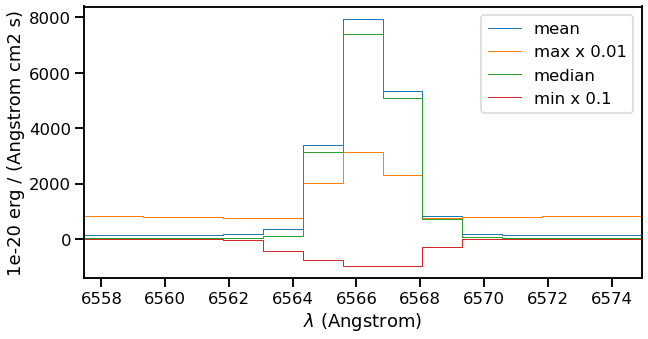

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
hacube.mean(axis=(1, 2)).plot(label="mean")
(0.01*hacube.max(axis=(1, 2))).plot(label="max x 0.01")
hacube.median(axis=(1, 2)).plot(label="median")
(0.1*hacube.min(axis=(1, 2))).plot(label="min x 0.1")
ax.legend()

## Subtract the continuum

On the plus side, it looks like there is never any significant continuum slope, so we can just calculate an average continuum level to subtract:

In [5]:
left_continuum = cube.select_lambda(6558.0, 6562.0).mean(axis=0)
right_continuum = cube.select_lambda(6572.0, 6576.0).mean(axis=0)
ha_cont = 0.5 * (left_continuum + right_continuum)

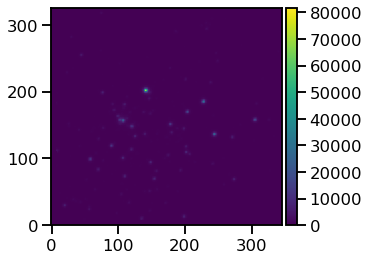

In [6]:
ha_cont.plot(colorbar="v")

Promote the continuum image to a cube by taking a copy of the the line cube and pasting in new data and variance: 

In [7]:
contcube = hacube.copy()
contcube.data = np.ones_like(contcube.data) * ha_cont.data[None, :, :]
contcube.var = np.ones_like(contcube.var) * ha_cont.var[None, :, :]

Subtract the continuum.

In [8]:
hacube_contsub = hacube - contcube 

Another way of doing it would have been to just subtract `ha_cont.data[None, :, :]` from the `.data` array of `hacube`.  But in that case, the `.var` would not have been propagated automatically and we would have to calculate it by hand. 

Now we do the same plot:

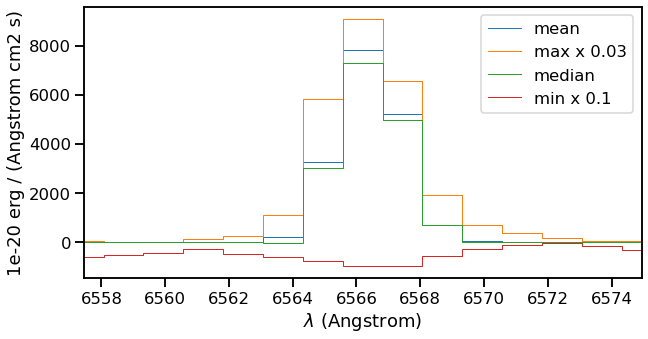

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
hacube_contsub.mean(axis=(1, 2)).plot(label="mean")
(0.03*hacube_contsub.max(axis=(1, 2))).plot(label="max x 0.03")
hacube_contsub.median(axis=(1, 2)).plot(label="median")
(0.1*hacube_contsub.min(axis=(1, 2))).plot(label="min x 0.1")
ax.legend()

This looks good – the continuum has been eliminated in all but the min aggregation, which is presumably dominated by a small number of pixels that have strange profiles.

## Make a cube of wavelengths

It is is easy to get a 1D array of the wavelengths:

In [10]:
waves = hacube_contsub.wave.coord()
waves

array([6557.44482422, 6558.69482422, 6559.94482422, 6561.19482422,
       6562.44482422, 6563.69482422, 6564.94482422, 6566.19482422,
       6567.44482422, 6568.69482422, 6569.94482422, 6571.19482422,
       6572.44482422, 6573.69482422, 6574.94482422])

But there seems no built-in way to get a cube of them, so we will construct it ourselves:

In [11]:
wavcube = hacube_contsub.clone(np.ones, np.zeros)
wavcube.data *= waves[:, None, None]
wavcube.unit = u.angstrom
wavcube.info()

[INFO] 15 x 326 x 346 Cube (no name)
[INFO] .data(15 x 326 x 346) (Angstrom), .var(15 x 326 x 346)
[INFO] center:(-72:10:31.853,00:59:02.986) size:(65.200",69.200") step:(0.200",0.200") rot:-0.0 deg frame:FK5
[INFO] wavelength: min:6557.44 max:6574.94 step:1.25 Angstrom


Note that we used the `.clone` method to get a new empty cube with the same coordinates, which we initialized with all ones as data and all zeros as variances (because there are no uncertainties in the wavelengths).  Then we used broadcasting to multiply the data by the 1D wavelength array and set the unit correctly.

## Calculate the moments

To reduce effects noise, especially in the higher moments, we use the core window of 6562 to 6572 in between the continuum-fitting ranges

In [12]:
hacore = hacube_contsub.select_lambda(6562.0, 6572.0)
wavcore = wavcube.select_lambda(6562.0, 6572.0)

The velocity moments are now trivial sums over this window.  

In [13]:
mom0 = hacore.sum(axis=0)
wav0 = 6566.5
mom1 = mom0.copy()
mom1.data = np.sum(hacore.data * (wavcore.data - wav0), axis=0) / mom0.data
# mom1.mask = mom1.mask | (mom0.data < 0.0)

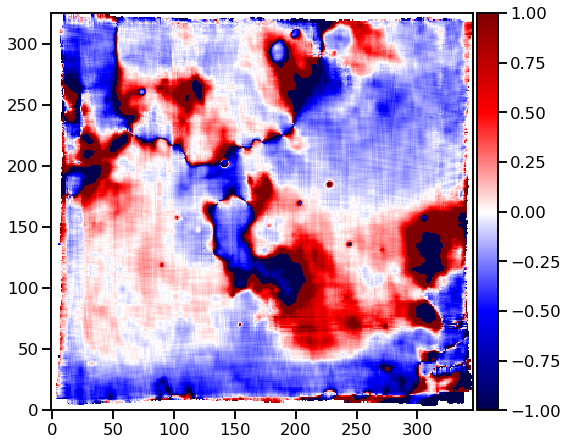

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
mom1.plot(
    cmap="seismic",
    vmin=-1.0, 
    vmax=1.0,
    colorbar="v",
)

## Try and deal with sky over-subtraction

Look at where Ha brightness is negative, and overlay with positions of stars (continuum is high)

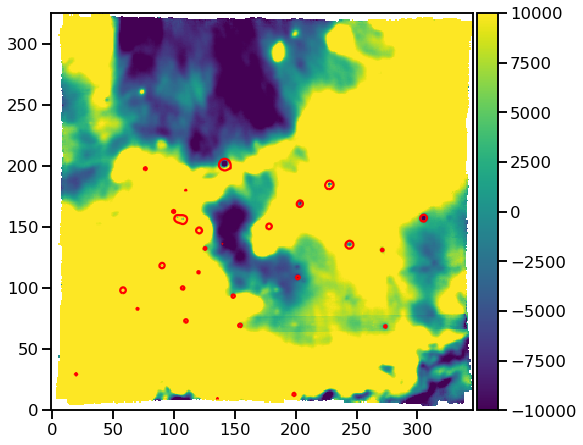

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
mom0.plot(
#    vmin=0.5*mom0.data.min(),
#    vmax=0.0,
    vmin=-10000,
    vmax=10000,
    cmap="viridis",
    colorbar="v",
)
ax.contour(ha_cont.data, levels=[5000], colors="r")

Look at some of the line profiles in the negative zones:

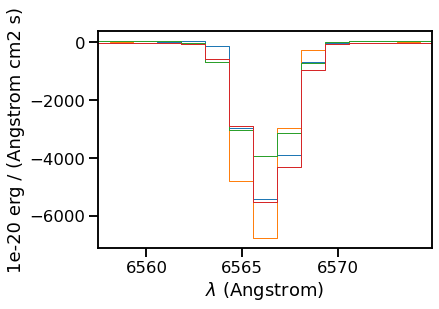

In [16]:
hacube[:, 300, 60].plot()
hacube[:, 10, 300].plot()
hacube[:, 150, 150].plot()
hacube[:, 260, 160].plot()

So what happens if we take the deepest one of those (in the lower right corner) and subtract it from each of the others:

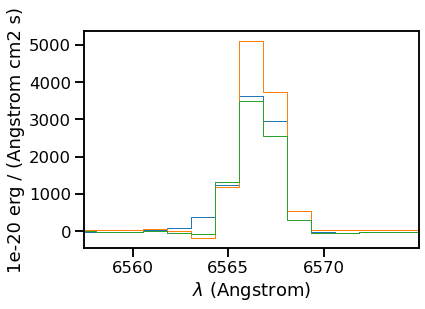

In [42]:
# skyspec = hacube[:, 10, 300]
starmask2d = ha_cont.data > 1000.0
bmask2d = hacore.sum(axis=0).data > -20000
skycube = hacube.copy()
skycube.mask = skycube.mask | starmask2d[None, :, :] | bmask2d[None, :, :]
skyspec = skycube.mean(axis=(1, 2))
(hacube[:, 300, 60] - skyspec).plot()
(hacube[:, 150, 150] - skyspec).plot()
(hacube[:, 260, 160] - skyspec).plot()

That  doesn't quite work because it is from a region that is particularly blue-shifted.  But we will try it anyhow.

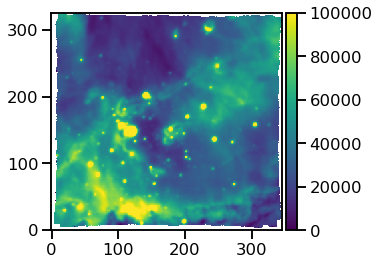

In [43]:
(hacube - skyspec).sum(axis=0).plot(vmin=0.0, vmax=1e5, colorbar="v")

Redo the moments, but subtracting skyspec first:

In [44]:
_hacube_contsub = hacube - contcube - skyspec
_hacore = _hacube_contsub.select_lambda(6562.0, 6572.0)
_mom0 = _hacore.sum(axis=0)
_mom1 = _mom0.copy()
_mom1.data = np.sum(_hacore.data * (wavcore.data - wav0), axis=0) / _mom0.data

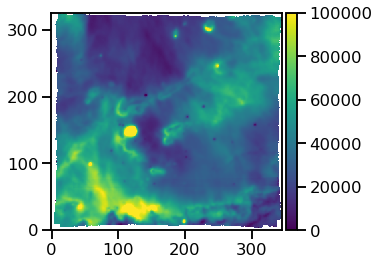

In [45]:
_mom0.plot(vmin=0.0, vmax=1e5, colorbar="v")

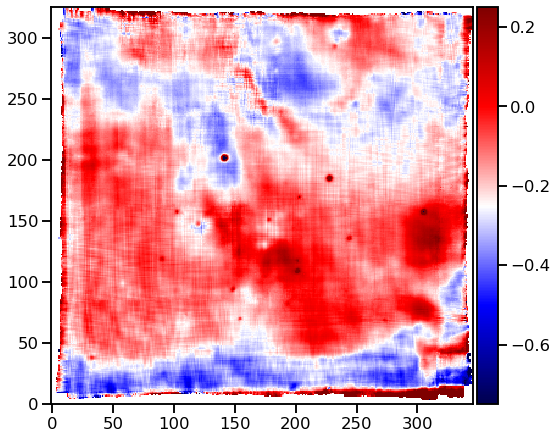

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
_mom1.plot(
    cmap="seismic",
    vmin=-0.75, 
    vmax=0.25,
    colorbar="v",
)

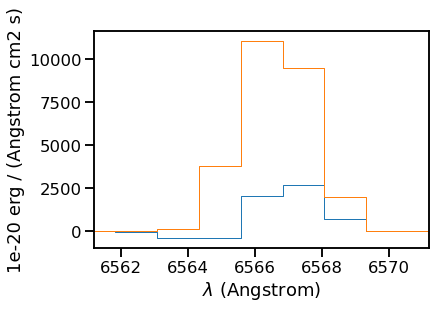

In [47]:
hacore[:, 70, 250].plot()
_hacore[:, 70, 250].plot()

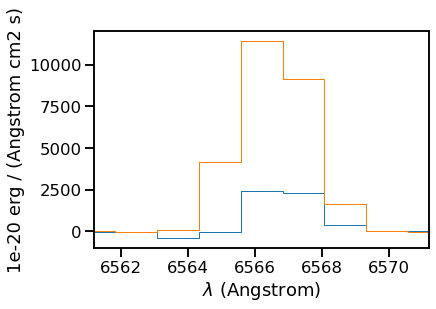

In [48]:
hacore[:, 75, 200].plot()
_hacore[:, 75, 200].plot()

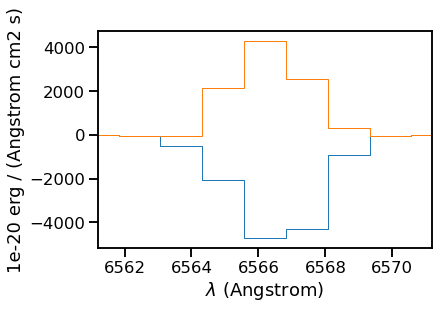

In [49]:
hacore[:, 250, 160].plot()
_hacore[:, 250, 160].plot()

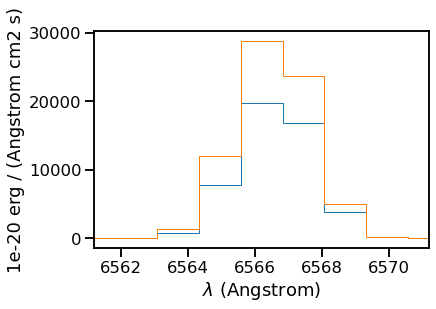

In [50]:
hacore[:, 100, 30].plot()
_hacore[:, 100, 30].plot()

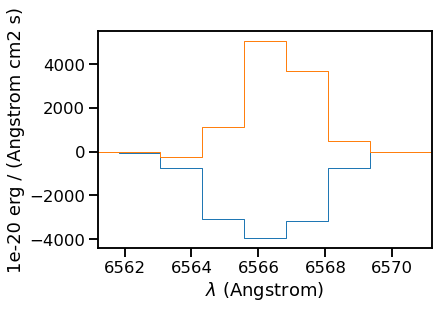

In [51]:
hacore[:, 150, 150].plot()
_hacore[:, 150, 150].plot()

### Try looking at joint distribution of unnormalized moments

The unnormalized moments should behave better. 

In [52]:
mom0 = hacore.sum(axis=0)
mom1 = mom0.copy()
#wav0 = 6566.5
wav0 = 6566.6
mom1.data = np.sum(hacore.data * (wavcore.data - wav0), axis=0)
mom2 = mom0.copy()
mom2.data = np.sum(hacore.data * (wavcore.data - wav0)**2, axis=0)

Note that we do not divide `mom1` by `mom0`

In [53]:
import pandas as pd
sns.set_color_codes()

In [54]:
starmask = ha_cont.data > 1e4
m = starmask | mom0.mask | (mom0.data > 3e4) | (np.abs(mom1.data) > 1e4)
df = pd.DataFrame({
    "mom0": mom0.data[~m],
    "mom1": mom1.data[~m],
    "mom2": mom2.data[~m],
})
df.describe()

,mom0,mom1,mom2
count,75503.000000,75503.000000,75503.000000
mean,7644.038689,-694.515483,5846.967404
std,11574.557320,3787.111728,15501.625025
min,-23961.928188,-9999.811775,-79087.283453
25%,-1636.873354,-3057.364577,-5968.545619
50%,7118.550131,-128.920670,4679.404027
75%,16757.916761,1934.835455,17292.856219
max,29998.171920,9997.417081,63102.143548


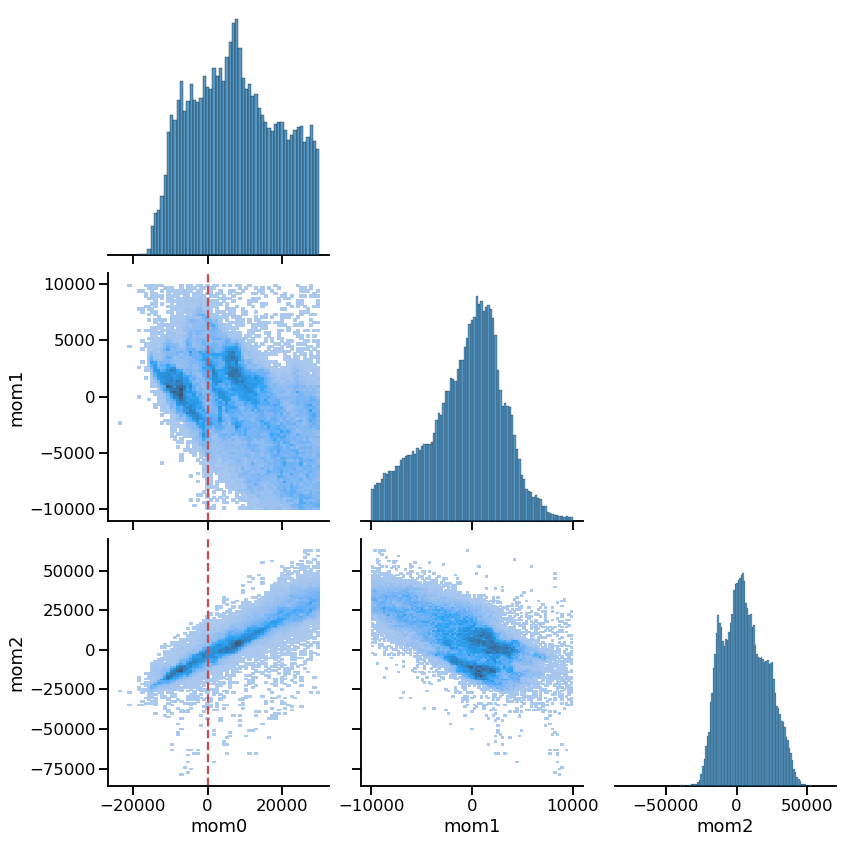

In [55]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r", linestyle="dashed")
g.axes[2, 0].axvline(0.0, color="r", linestyle="dashed")

In [56]:
_mom0 = _hacore.sum(axis=0)
_mom1 = _mom0.copy()
_mom1.data = np.sum(_hacore.data * (wavcore.data - wav0), axis=0)
_mom2 = _mom0.copy()
_mom2.data = np.sum(_hacore.data * (wavcore.data - wav0)**2, axis=0)

In [77]:
m = (
    starmask 
    | _mom0.mask 
    | (_mom0.data > 10e4) 
    | (_mom1.data < -2.5e4) | (_mom1.data > 0.5e4)
    | (_mom2.data < -1e4)  | (_mom2.data > 1.5e5) 
)
df = pd.DataFrame({
    "mom0": _mom0.data[~m],
    "mom1": _mom1.data[~m],
    "mom2": _mom2.data[~m],
})
df.describe()

,mom0,mom1,mom2
count,101182.000000,101182.000000,101182.000000
mean,37583.565324,-6638.128369,44775.073614
std,17875.928483,5400.439291,24330.150906
min,-2242.896124,-24993.539377,-9907.933448
25%,23493.512740,-9965.412680,26013.990600
50%,34886.858011,-5488.630206,40332.064400
75%,50432.677267,-2681.137209,61824.963844
max,99925.456894,4995.102680,149692.491028


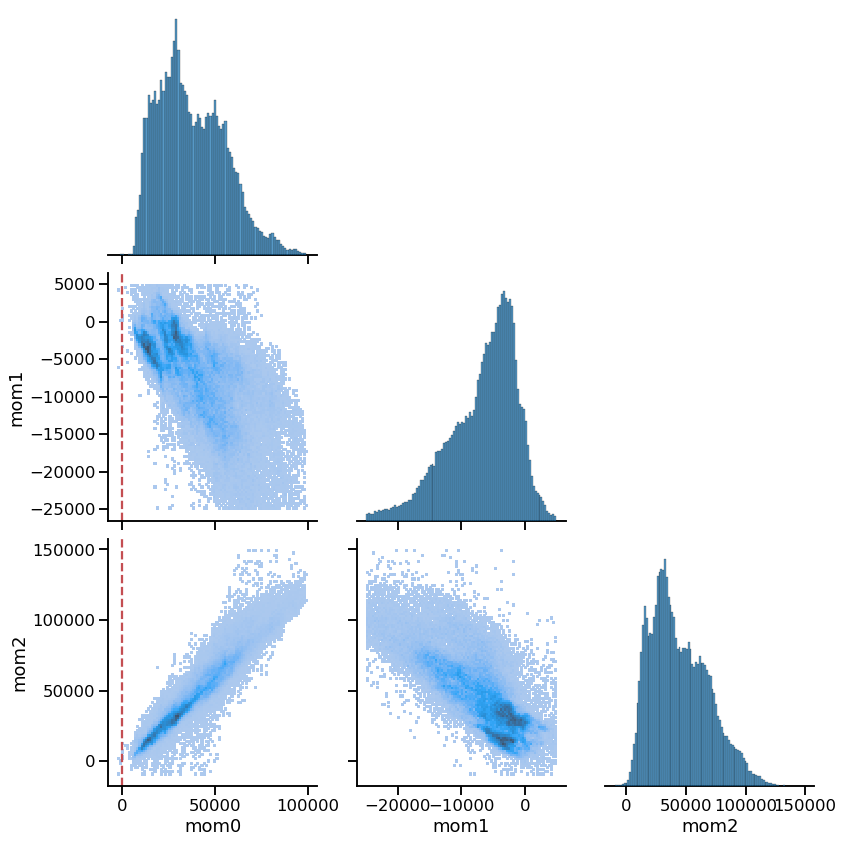

In [78]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r", linestyle="dashed")
g.axes[2, 0].axvline(0.0, color="r", linestyle="dashed")

Back to normalized moments

In [81]:
_mom0 = _hacore.sum(axis=0)
_mom1 = _mom0.copy()
_mom1.data = np.sum(_hacore.data * (wavcore.data - wav0), axis=0) / _mom0.data
_mom2 = _mom0.copy()
_mom2.data = np.sum(_hacore.data * (wavcore.data - wav0 - _mom1.data)**2, axis=0) / _mom0.data

In [92]:
m = (
    starmask 
    | _mom0.mask 
    | (_mom0.data > 10e4) 
    | (_mom1.data < -0.5) | (_mom1.data > 0.25)
    | (_mom2.data > 1.75) | (_mom2.data < 0.5)
)
df2 = pd.DataFrame({
    "log10 mom0": np.log10(_mom0.data[~m]),
    "mom1": _mom1.data[~m],
    "mom2": _mom2.data[~m],
})
df2.describe()

,log10 mom0,mom1,mom2
count,101356.000000,101356.000000,101356.000000
mean,4.532182,-0.173636,1.123128
std,0.228221,0.115953,0.182185
min,3.562473,-0.499934,0.500194
25%,4.382102,-0.258834,1.021315
50%,4.553195,-0.172874,1.120621
75%,4.711774,-0.094095,1.228774
max,4.999905,0.249105,1.749708


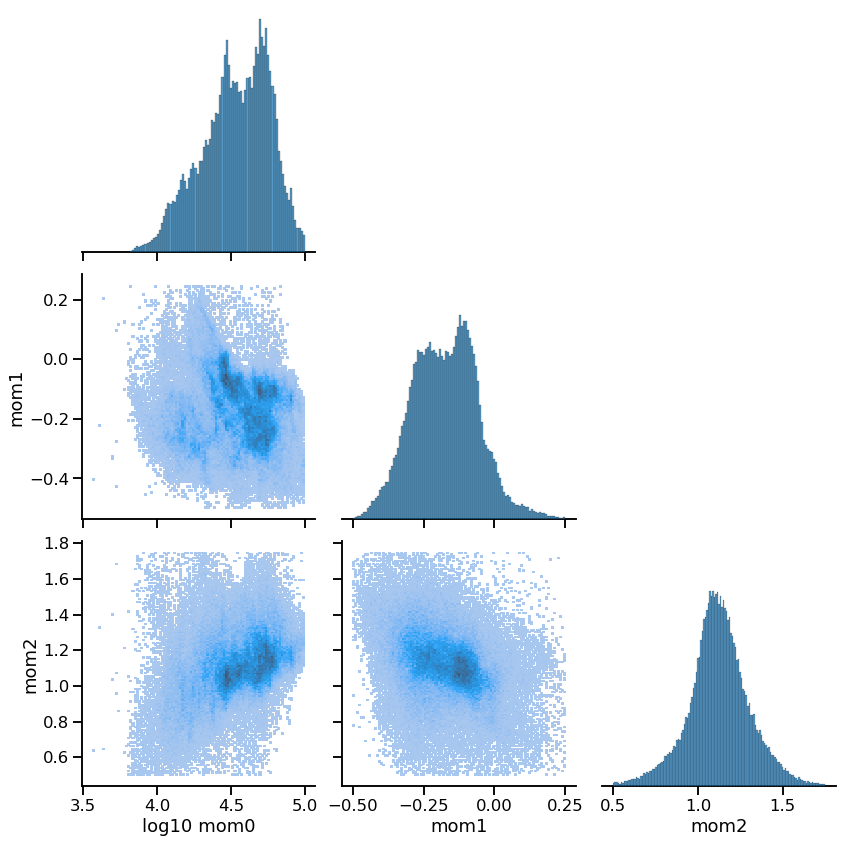

In [93]:
g = sns.pairplot(
    df2,
    kind="hist",
    height=4,
    corner=True,
)

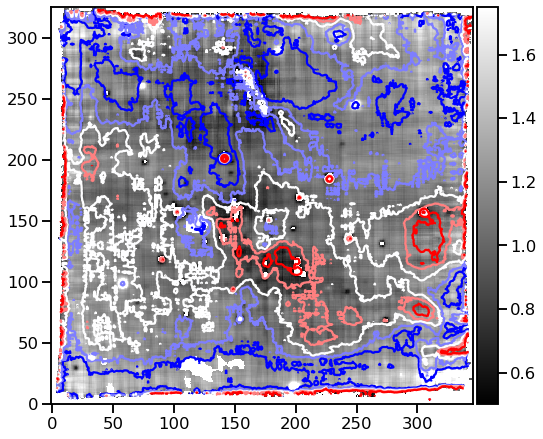

In [108]:
fig, ax = plt.subplots(figsize=(8, 8))
_mom2.mask = _mom2.mask | m
_mom2.plot(
    cmap="gray",
    vmin=0.5, 
    vmax=1.75,
    colorbar="v",
)
ax.contour(_mom1.data, levels=[-0.3, -0.2, -0.1, 0.0, 0.1], cmap="bwr")